GANSUはCUDA Compute Capability >= 8.0を要求しているので\
Google Colabで実行する場合はT4 GPU不可（GPU4PySCFはT4 GPUでも可）。\
今回の計算環境は下記。\
CPU: AMD Ryzen 5 3600 6-Core Processor\
GPU: NVIDIA GeForce RTX 3060Ti

In [4]:
# 分子構造生成用に準備
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 32.4 MB/s  0:00:01m0:00:0100:01


# GANSU

## インストール

In [1]:
!git clone https://github.com/Yasuaki-Ito/GANSU.git

Cloning into 'GANSU'...
remote: Enumerating objects: 1336, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (267/267), done.
remote: Total 1336 (delta 448), reused 418 (delta 325), pack-reused 744 (from 1)
Receiving objects: 100% (1336/1336), 9.47 MiB | 14.02 MiB/s, done.
Resolving deltas: 100% (831/831), done.


In [2]:
!cd GANSU && mkdir build && cd build && cmake ../

-- The CUDA compiler identification is NVIDIA 12.6.20 with host compiler GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (3.0s)
-- Generating done (0.0s)
-- Build files have been written to: /workspace/GANSU/build


In [7]:
# nprocを自動取得してクリーンビルド, -diag-suppressでwarning出力抑制
!cd GANSU/build && \
 rm -rf CMakeCache.txt CMakeFiles/ && \
 cmake -DCMAKE_CUDA_FLAGS="-diag-suppress 177" .. && \
 make -j$(nproc)

-- The CUDA compiler identification is NVIDIA 12.6.20 with host compiler GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting CUDA compiler ABI info
-- Detecting CUDA compiler ABI info - done
-- Check for working CUDA compiler: /usr/local/cuda/bin/nvcc - skipped
-- Detecting CUDA compile features
-- Detecting CUDA compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring done (2.9s)
-- Generating done (0.0s)
-- Build files have been written to: /workspace/GANSU/build
[ 11%] Building CUDA object CMakeFiles/int2c2e.dir/src/int2c2e.cu.o
[  6%] Building CUDA object CMakeFiles/int1e.dir/src/int1e.cu.o
[ 11%] Building CUDA object CMakeFiles/int2e.dir/src/int2e.cu.o
[ 11%] Building CUDA object CMakeFiles/int3c2e.dir/src/int3c2e.cu.o
[ 11%] Building CUDA object CMakeFiles/int2e_direct.d

### GANSU動作確認

In [9]:
# CCSD計算
!cd GANSU/build && ./HF_main -x ../xyz/H2O.xyz -g ../basis/sto-3g.gbs --post_hf_method ccsd --eri_method stored

CUDA Runtime Version: 12.6.0
CUDA Driver Version: 12.6.0
cuBLAS Version: 12.6.0
cuSOLVER Version: 11.6.4
Message: Post-HF method is CCSD.
[INT1E] One electron integrals are computed using the Hybrid method.
[00:00.000] START: compute_nuclear_repulsion_energy
[00:00.000] END:   compute_nuclear_repulsion_energy after 0.034 ms
[00:00.000] START: compute_core_hamiltonian_matrix
[00:00.007] END:   compute_core_hamiltonian_matrix after 6.993 ms
[00:00.007] START: precompute_eri_matrix
[00:00.026] END:   precompute_eri_matrix after 19.25 ms
[00:00.026] START: compute_transform_matrix
[00:00.070] END:   compute_transform_matrix after 43.853 ms
[00:00.070] START: guess_initial_fock_matrix
[00:00.070] START: compute_density_matrix
[00:00.071] END:   compute_density_matrix after 0.155 ms
[00:00.071] START: compute_fock_matrix
[00:00.071] END:   compute_fock_matrix after 0.085 ms
[00:00.071] END:   guess_initial_fock_matrix after 0.922 ms
[00:00.071] SCF Iteration 0
[00:00.071] START: compute_coef

## GANSUでHF/sto-3g計算時間測定

>>> Phase 1: Generating structures...
>>> Phase 2: Benchmarking with GANSU Computing time (2 warmup + 10 runs)...
--- Molecule C1 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C2 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C3 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C4 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C5 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C6 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C7 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C8 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)......

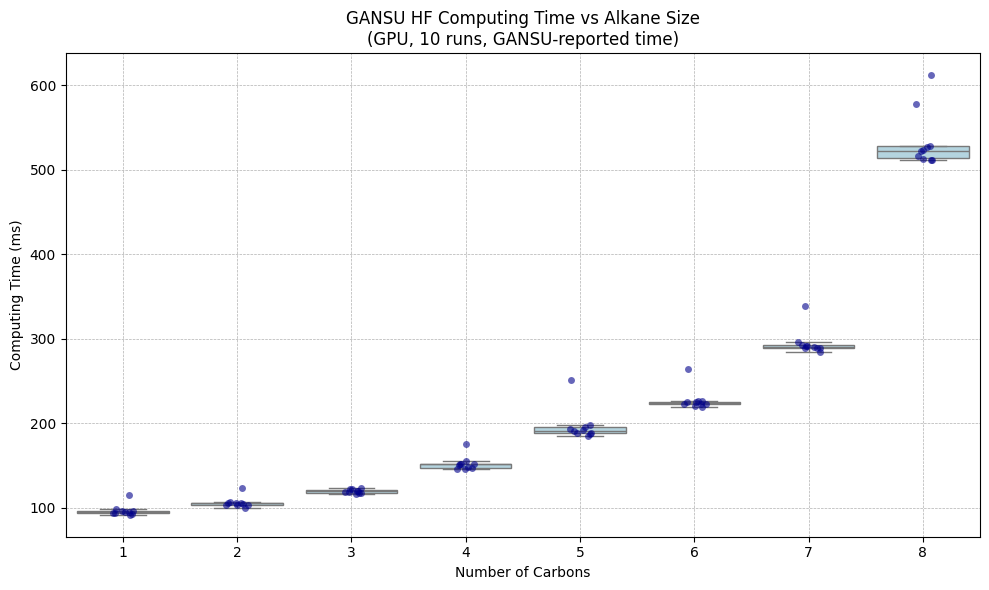

In [11]:
import subprocess
import csv
import re
import numpy as np
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# --- 設定 ---
ALKANES = {n: "C" * n for n in range(1, 9)}
N_WARMUP = 2      # ウォームアップ回数（データには含めない）
N_MEASURE = 10    # 本番計測回数
TIMEOUT_SEC = 1200 # 1回の計算のタイムアウト（安全装置）
GANSU_BIN = "./HF_main"
GANSU_CWD = Path("GANSU/build").resolve()
BASIS_SET = "../basis/sto-3g.gbs"
OUTPUT_CSV = "gansu_hf.csv"

# --- ヘルパー関数 ---

def generate_structure(smiles: str, xyz_path: Path) -> None:
    """RDKitで構造生成（計測前に実行）"""
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)
    conf = mol.GetConformer()
    with open(xyz_path, "w") as f:
        f.write(f"{mol.GetNumAtoms()}\n\n")
        for i in range(mol.GetNumAtoms()):
            pos = conf.GetAtomPosition(i)
            f.write(f"{mol.GetAtomWithIdx(i).GetSymbol()} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}\n")

def run_single_calculation(xyz_path: Path) -> float:
    """
    GANSUを実行し、ログからComputing timeを抽出する。
    """
    xyz_abs = xyz_path.resolve()

    # GPU計算環境変数の設定
    env = os.environ.copy()
    env["CUDA_VISIBLE_DEVICES"] = "0"

    try:
        result = subprocess.run(
            [
                GANSU_BIN,
                "-x", str(xyz_abs),
                "-g", BASIS_SET,
            ],
            capture_output=True,
            text=True,
            cwd=GANSU_CWD,
            timeout=TIMEOUT_SEC,
            env=env
        )

        # エラーチェック
        if result.returncode != 0:
            raise RuntimeError(f"Return Code {result.returncode}: {result.stderr}")

        # 標準出力からComputing timeを抽出
        # 例: "Computing time: 1234.56 [ms]"
        computing_time_match = re.search(r"Computing time:\s*([\d.]+)\s*\[ms\]", result.stdout)
        if not computing_time_match:
            raise RuntimeError("Could not find 'Computing time' in GANSU output")

        computing_time_ms = float(computing_time_match.group(1))
        return computing_time_ms

    except subprocess.TimeoutExpired:
        raise RuntimeError(f"Timeout after {TIMEOUT_SEC}s")

# --- メイン処理 ---

def main():
    # 1. 準備フェーズ
    print(">>> Phase 1: Generating structures...")
    xyz_files = {}
    for n, smiles in ALKANES.items():
        p = Path(f"c{n}.xyz")
        generate_structure(smiles, p)
        xyz_files[n] = p

    all_data = []

    # 2. 計測フェーズ
    print(f">>> Phase 2: Benchmarking with GANSU Computing time ({N_WARMUP} warmup + {N_MEASURE} runs)...")

    for n, xyz_path in xyz_files.items():
        print(f"--- Molecule C{n} ---")

        # Warm-up (OSキャッシュ/GPUステートのホット化)
        print(f"   Warm-up ({N_WARMUP} times)...", end="", flush=True)
        for _ in range(N_WARMUP):
            try:
                run_single_calculation(xyz_path)
                print(".", end="", flush=True)
            except Exception as e:
                print(f" (Warmup failed: {e})")
        print(" Done.")

        # Measurement
        print(f"   Measuring ({N_MEASURE} times)...", end="", flush=True)
        success_count = 0
        for i in range(N_MEASURE):
            try:
                t_ms = run_single_calculation(xyz_path)
                all_data.append({
                    "n_carbon": n,
                    "run_id": i,
                    "time_ms": t_ms
                })
                print(".", end="", flush=True)
                success_count += 1
            except Exception as e:
                print(f"X({e})", end="", flush=True)
        print(f" Finished ({success_count}/{N_MEASURE} success).")

    # 3. データ保存
    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n>>> Raw data saved to {OUTPUT_CSV}")

    if df.empty:
        print("No successful data collected.")
        return

    # 4. 統計サマリー出力
    summary = df.groupby("n_carbon")["time_ms"].agg(["mean", "std", "median", "min", "max", "count"])
    print("\n>>> Statistical Summary:")
    print(summary)
    summary.to_csv("summary_gansu_hf.csv")

    # 5. プロット
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="n_carbon", y="time_ms", data=df, color="lightblue", showfliers=False)
    sns.stripplot(x="n_carbon", y="time_ms", data=df, color="darkblue", alpha=0.6, jitter=True)

    plt.title(f"GANSU HF Computing Time vs Alkane Size\n(GPU, {N_MEASURE} runs, GANSU-reported time)")
    plt.xlabel("Number of Carbons")
    plt.ylabel("Computing Time (ms)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("gansu_hf.png", dpi=600)
    plt.show()

if __name__ == "__main__":
    main()

## GANSUでCCSD/sto-3g計算時間測定

>>> Phase 1: Generating structures...
>>> Phase 2: Benchmarking with GANSU Computing time (2 warmup + 10 runs)...
--- Molecule C1 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C2 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C3 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C4 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C5 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C6 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C7 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C8 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)......

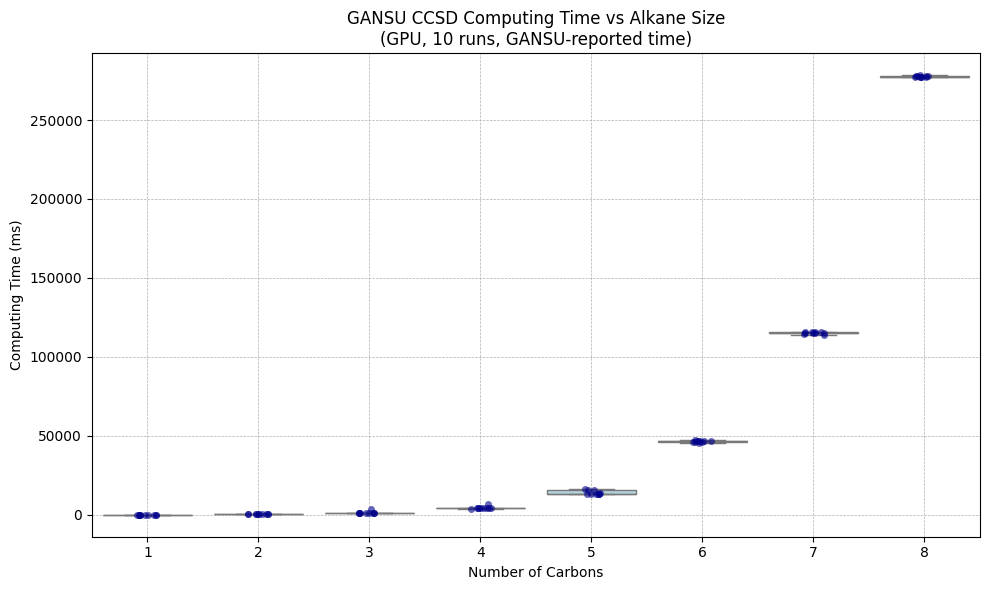

In [12]:
import subprocess
import csv
import re
import numpy as np
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# --- 設定 ---
ALKANES = {n: "C" * n for n in range(1, 9)}
N_WARMUP = 2      # ウォームアップ回数（データには含めない）
N_MEASURE = 10    # 本番計測回数
TIMEOUT_SEC = 1200 # 1回の計算のタイムアウト（安全装置）
GANSU_BIN = "./HF_main"
GANSU_CWD = Path("GANSU/build").resolve()
BASIS_SET = "../basis/sto-3g.gbs"
OUTPUT_CSV = "gansu_ccsd.csv"

# --- ヘルパー関数 ---

def generate_structure(smiles: str, xyz_path: Path) -> None:
    """RDKitで構造生成（計測前に実行）"""
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)
    conf = mol.GetConformer()
    with open(xyz_path, "w") as f:
        f.write(f"{mol.GetNumAtoms()}\n\n")
        for i in range(mol.GetNumAtoms()):
            pos = conf.GetAtomPosition(i)
            f.write(f"{mol.GetAtomWithIdx(i).GetSymbol()} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}\n")

def run_single_calculation(xyz_path: Path) -> float:
    """
    GANSUを実行し、ログからComputing timeを抽出する。
    """
    xyz_abs = xyz_path.resolve()

    # GPU計算環境変数の設定
    env = os.environ.copy()
    env["CUDA_VISIBLE_DEVICES"] = "0"

    try:
        result = subprocess.run(
            [
                GANSU_BIN,
                "-x", str(xyz_abs),
                "-g", BASIS_SET,
                "--post_hf_method", "ccsd",
                "--eri_method", "stored"
            ],
            capture_output=True,
            text=True,
            cwd=GANSU_CWD,
            timeout=TIMEOUT_SEC,
            env=env
        )

        # エラーチェック
        if result.returncode != 0:
            raise RuntimeError(f"Return Code {result.returncode}: {result.stderr}")

        # 標準出力からComputing timeを抽出
        # 例: "Computing time: 1234.56 [ms]"
        computing_time_match = re.search(r"Computing time:\s*([\d.]+)\s*\[ms\]", result.stdout)
        if not computing_time_match:
            raise RuntimeError("Could not find 'Computing time' in GANSU output")

        computing_time_ms = float(computing_time_match.group(1))
        return computing_time_ms

    except subprocess.TimeoutExpired:
        raise RuntimeError(f"Timeout after {TIMEOUT_SEC}s")

# --- メイン処理 ---

def main():
    # 1. 準備フェーズ
    print(">>> Phase 1: Generating structures...")
    xyz_files = {}
    for n, smiles in ALKANES.items():
        p = Path(f"c{n}.xyz")
        generate_structure(smiles, p)
        xyz_files[n] = p

    all_data = []

    # 2. 計測フェーズ
    print(f">>> Phase 2: Benchmarking with GANSU Computing time ({N_WARMUP} warmup + {N_MEASURE} runs)...")

    for n, xyz_path in xyz_files.items():
        print(f"--- Molecule C{n} ---")

        # Warm-up (OSキャッシュ/GPUステートのホット化)
        print(f"   Warm-up ({N_WARMUP} times)...", end="", flush=True)
        for _ in range(N_WARMUP):
            try:
                run_single_calculation(xyz_path)
                print(".", end="", flush=True)
            except Exception as e:
                print(f" (Warmup failed: {e})")
        print(" Done.")

        # Measurement
        print(f"   Measuring ({N_MEASURE} times)...", end="", flush=True)
        success_count = 0
        for i in range(N_MEASURE):
            try:
                t_ms = run_single_calculation(xyz_path)
                all_data.append({
                    "n_carbon": n,
                    "run_id": i,
                    "time_ms": t_ms
                })
                print(".", end="", flush=True)
                success_count += 1
            except Exception as e:
                print(f"X({e})", end="", flush=True)
        print(f" Finished ({success_count}/{N_MEASURE} success).")

    # 3. データ保存
    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n>>> Raw data saved to {OUTPUT_CSV}")

    if df.empty:
        print("No successful data collected.")
        return

    # 4. 統計サマリー出力
    summary = df.groupby("n_carbon")["time_ms"].agg(["mean", "std", "median", "min", "max", "count"])
    print("\n>>> Statistical Summary:")
    print(summary)
    summary.to_csv("summary_gansu_ccsd.csv")

    # 5. プロット
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="n_carbon", y="time_ms", data=df, color="lightblue", showfliers=False)
    sns.stripplot(x="n_carbon", y="time_ms", data=df, color="darkblue", alpha=0.6, jitter=True)

    plt.title(f"GANSU CCSD Computing Time vs Alkane Size\n(GPU, {N_MEASURE} runs, GANSU-reported time)")
    plt.xlabel("Number of Carbons")
    plt.ylabel("Computing Time (ms)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("gansu_ccsd.png", dpi=600)
    plt.show()

if __name__ == "__main__":
    main()

# GPU4PySCF

## インストール

In [13]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Fri_Jun_14_16:34:21_PDT_2024
Cuda compilation tools, release 12.6, V12.6.20
Build cuda_12.6.r12.6/compiler.34431801_0


In [ ]:
# Dockerfile側でインストールしているので不要(Google Colabで実行する場合はコメントアウトを外す)
# # CUDA 12.x の場合
# !pip3 install gpu4pyscf-cuda12x
# !pip3 install cutensor-cu12

## GPU4PySCF動作確認

In [15]:
import pyscf
from gpu4pyscf import scf
from gpu4pyscf.cc import ccsd_incore

# 分子の定義  (GANSUの水分子と同じ構造)
mol = pyscf.M(atom=[
    [8 , (0. , 0.     , 0.127)],
    [1 , (0. , 0.758 , -0.509)],
    [1 , (0. , -0.758  , -0.509)],
], basis='sto-3g', verbose=0)

# GPUでHF計算を実行
mf_gpu = scf.RHF(mol)
mf_gpu.run()

# GPUでCCSD計算を実行
cc_gpu = ccsd_incore.CCSD(mf_gpu)
cc_gpu.run()

print(f"HFエネルギー: {mf_gpu.e_tot}")
print(f"CCSDエネルギー: {cc_gpu.e_tot}")

HFエネルギー: -74.96590116155087
CCSDエネルギー: -75.02029742635752


In [14]:
import cupy; print(cupy.cuda.runtime.runtimeGetVersion())  # 12050や12090など数字が出ればOK
import gpu4pyscf.lib.cutensor as ct; print(ct.cutensor)    # NoneでなければOK

12090
<module 'cupyx.cutensor' from '/usr/local/lib/python3.10/dist-packages/cupyx/cutensor.cpython-310-x86_64-linux-gnu.so'>


## GPU4PySCFでHF/sto-3g計算時間測定

>>> Phase 1 & 2: Running GPU4PySCF (Warmup=2, Measure=10)...
--- Molecule C1 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C2 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C3 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C4 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C5 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C6 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C7 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C8 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).

>>> Raw data saved

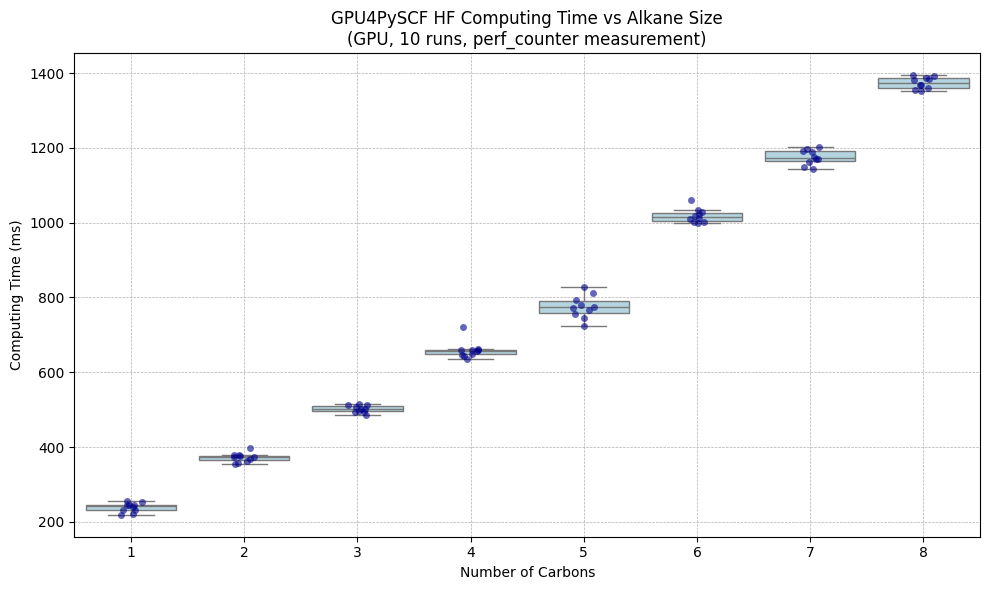

In [16]:
import time
import csv
import gc
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import cupy

# RDKit
from rdkit import Chem
from rdkit.Chem import AllChem

# PySCF & GPU4PySCF
import pyscf
from gpu4pyscf import scf

# --- 設定 ---
# 比較のためGANSUコードと完全に同じ範囲・回数にする
ALKANES = {n: "C" * n for n in range(1, 9)}
N_WARMUP = 2
N_MEASURE = 10
BASIS_SET = 'sto-3g'
OUTPUT_CSV = "gpu4pyscf_hf.csv"

# --- ヘルパー関数 ---

def generate_xyz_string(smiles: str) -> str:
    """
    RDKitで構造生成し、PySCFが読めるXYZ形式の文字列を返す。
    (GANSUコードのgenerate_structureと等価だが、ファイルIOを避けて高速化)
    """
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()
    atom_lines = []
    for i in range(mol.GetNumAtoms()):
        sym = mol.GetAtomWithIdx(i).GetSymbol()
        pos = conf.GetAtomPosition(i)
        atom_lines.append(f"{sym} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}")

    return "\n".join(atom_lines)

def run_single_calculation(xyz_str: str) -> float:
    """
    GPU4PySCFを実行し、経過時間(ms)を返す。
    """
    # 分子定義
    mol = pyscf.M(atom=xyz_str, basis=BASIS_SET, verbose=0)

    # GPU固定（必須）
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # 計測前にGPUに残っている前のタスクを確実に終わらせる
    cupy.cuda.Device().synchronize()

    # --- 計測開始 ---
    t0 = time.perf_counter()

    # HF計算
    mf = scf.RHF(mol)
    mf.run()

    # 計測終了前にGPUの作業完了を確実に待つ
    cupy.cuda.Device().synchronize()

    # --- 計測終了 ---
    t1 = time.perf_counter()

    # 簡易エラーチェック
    if not np.isfinite(mf.e_tot):
        raise RuntimeError("HF Energy is NaN/Inf")

    # クリーンアップ (VRAMリーク防止)
    del mf
    del mol
    gc.collect()

    # msに変換
    return (t1 - t0) * 1000.0

# --- メイン処理 ---

def main():
    all_data = []
    print(f">>> Phase 1 & 2: Running GPU4PySCF (Warmup={N_WARMUP}, Measure={N_MEASURE})...")

    for n, smiles in ALKANES.items():
        print(f"--- Molecule C{n} ---")

        # 構造生成
        try:
            xyz_str = generate_xyz_string(smiles)
        except Exception as e:
            print(f"Structure generation failed: {e}")
            continue

        # Warm-up
        print(f"   Warm-up ({N_WARMUP} times)...", end="", flush=True)
        for _ in range(N_WARMUP):
            try:
                run_single_calculation(xyz_str)
                print(".", end="", flush=True)
            except Exception as e:
                print(f"X({e})", end="", flush=True)
            finally:
                gc.collect()
        print(" Done.")

        # Measurement
        print(f"   Measuring ({N_MEASURE} times)...", end="", flush=True)
        success_count = 0
        for i in range(N_MEASURE):
            try:
                t_ms = run_single_calculation(xyz_str)
                all_data.append({
                    "n_carbon": n,
                    "run_id": i,
                    "time_ms": t_ms
                })
                print(".", end="", flush=True)
                success_count += 1
            except Exception as e:
                print(f"X({e})", end="", flush=True)
            finally:
                gc.collect()

        print(f" Finished ({success_count}/{N_MEASURE} success).")

    # 3. データ保存
    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n>>> Raw data saved to {OUTPUT_CSV}")

    if df.empty:
        print("No successful data collected.")
        return

    # 4. 統計サマリー出力
    summary = df.groupby("n_carbon")["time_ms"].agg(["mean", "std", "median", "min", "max", "count"])
    print("\n>>> Statistical Summary:")
    print(summary)
    summary.to_csv("summary_gpu4pyscf_hf.csv")

    # 5. プロット (GANSUのコードと完全に同じスタイル・配色・サイズに統一)
    plt.figure(figsize=(10, 6))

    # 色指定: GANSUコードと同じ lightblue / darkblue を使用
    sns.boxplot(x="n_carbon", y="time_ms", data=df, color="lightblue", showfliers=False)
    sns.stripplot(x="n_carbon", y="time_ms", data=df, color="darkblue", alpha=0.6, jitter=True)

    # タイトルフォーマットを統一 (中身のツール名は変更)
    plt.title(f"GPU4PySCF HF Computing Time vs Alkane Size\n(GPU, {N_MEASURE} runs, perf_counter measurement)")
    plt.xlabel("Number of Carbons")
    plt.ylabel("Computing Time (ms)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # 保存
    plt.savefig("gpu4pyscf_hf.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

## GPU4PySCFでCCSD/sto-3g計算時間測定

>>> Phase 1 & 2: Running GPU4PySCF (Warmup=2, Measure=10)...
--- Molecule C1 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C2 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C3 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C4 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C5 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C6 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C7 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).
--- Molecule C8 ---
   Warm-up (2 times)..... Done.
   Measuring (10 times)............. Finished (10/10 success).

>>> Raw data saved

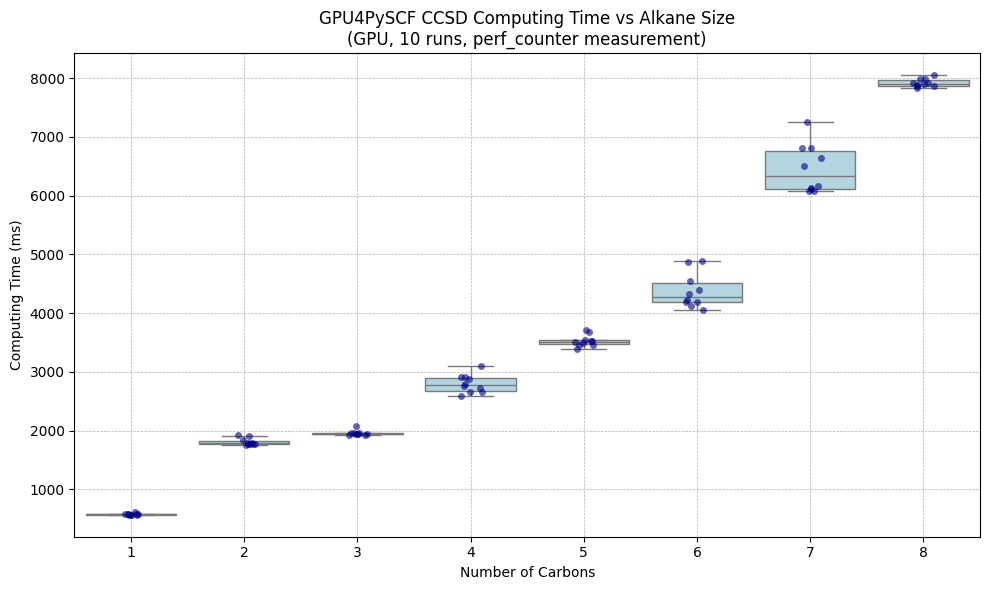

In [17]:
import time
import csv
import gc
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import cupy

# RDKit
from rdkit import Chem
from rdkit.Chem import AllChem

# PySCF & GPU4PySCF
import pyscf
from gpu4pyscf import scf
from gpu4pyscf.cc import ccsd_incore

# --- 設定 ---
# 比較のためGANSUコードと完全に同じ範囲・回数にする
ALKANES = {n: "C" * n for n in range(1, 9)}
N_WARMUP = 2
N_MEASURE = 10
BASIS_SET = 'sto-3g'
OUTPUT_CSV = "gpu4pyscf_ccsd.csv"

# --- ヘルパー関数 ---

def generate_xyz_string(smiles: str) -> str:
    """
    RDKitで構造生成し、PySCFが読めるXYZ形式の文字列を返す。
    (GANSUコードのgenerate_structureと等価だが、ファイルIOを避けて高速化)
    """
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.UFFOptimizeMolecule(mol)

    conf = mol.GetConformer()
    atom_lines = []
    for i in range(mol.GetNumAtoms()):
        sym = mol.GetAtomWithIdx(i).GetSymbol()
        pos = conf.GetAtomPosition(i)
        atom_lines.append(f"{sym} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}")

    return "\n".join(atom_lines)

def run_single_calculation(xyz_str: str) -> float:
    """
    GPU4PySCFを実行し、経過時間(ms)を返す。
    """
    # 分子定義
    mol = pyscf.M(atom=xyz_str, basis=BASIS_SET, verbose=0)

    # GPU固定（必須）
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"

    # 計測前にGPUに残っている前のタスクを確実に終わらせる
    cupy.cuda.Device().synchronize()

    # --- 計測開始 ---
    t0 = time.perf_counter()

    # HF計算
    mf = scf.RHF(mol)
    mf.run()

    # CCSD計算 (In-core)
    cc = ccsd_incore.CCSD(mf)
    cc.run()

    # 計測終了前にGPUの作業完了を確実に待つ
    cupy.cuda.Device().synchronize()

    # --- 計測終了 ---
    t1 = time.perf_counter()

    # 簡易エラーチェック
    if not np.isfinite(cc.e_tot):
        raise RuntimeError("CCSD Energy is NaN/Inf")

    # クリーンアップ (VRAMリーク防止)
    del cc
    del mf
    del mol
    gc.collect()

    # msに変換
    return (t1 - t0) * 1000.0

# --- メイン処理 ---

def main():
    all_data = []
    print(f">>> Phase 1 & 2: Running GPU4PySCF (Warmup={N_WARMUP}, Measure={N_MEASURE})...")

    for n, smiles in ALKANES.items():
        print(f"--- Molecule C{n} ---")

        # 構造生成
        try:
            xyz_str = generate_xyz_string(smiles)
        except Exception as e:
            print(f"Structure generation failed: {e}")
            continue

        # Warm-up
        print(f"   Warm-up ({N_WARMUP} times)...", end="", flush=True)
        for _ in range(N_WARMUP):
            try:
                run_single_calculation(xyz_str)
                print(".", end="", flush=True)
            except Exception as e:
                print(f"X({e})", end="", flush=True)
            finally:
                gc.collect()
        print(" Done.")

        # Measurement
        print(f"   Measuring ({N_MEASURE} times)...", end="", flush=True)
        success_count = 0
        for i in range(N_MEASURE):
            try:
                t_ms = run_single_calculation(xyz_str)
                all_data.append({
                    "n_carbon": n,
                    "run_id": i,
                    "time_ms": t_ms
                })
                print(".", end="", flush=True)
                success_count += 1
            except Exception as e:
                print(f"X({e})", end="", flush=True)
            finally:
                gc.collect()

        print(f" Finished ({success_count}/{N_MEASURE} success).")

    # 3. データ保存
    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"\n>>> Raw data saved to {OUTPUT_CSV}")

    if df.empty:
        print("No successful data collected.")
        return

    # 4. 統計サマリー出力
    summary = df.groupby("n_carbon")["time_ms"].agg(["mean", "std", "median", "min", "max", "count"])
    print("\n>>> Statistical Summary:")
    print(summary)
    summary.to_csv("summary_gpu4pyscf_ccsd.csv")

    # 5. プロット (GANSUのコードと完全に同じスタイル・配色・サイズに統一)
    plt.figure(figsize=(10, 6))

    # 色指定: GANSUコードと同じ lightblue / darkblue を使用
    sns.boxplot(x="n_carbon", y="time_ms", data=df, color="lightblue", showfliers=False)
    sns.stripplot(x="n_carbon", y="time_ms", data=df, color="darkblue", alpha=0.6, jitter=True)

    # タイトルフォーマットを統一 (中身のツール名は変更)
    plt.title(f"GPU4PySCF CCSD Computing Time vs Alkane Size\n(GPU, {N_MEASURE} runs, perf_counter measurement)")
    plt.xlabel("Number of Carbons")
    plt.ylabel("Computing Time (ms)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # 保存
    plt.savefig("gpu4pyscf_ccsd.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

# 結果のまとめプロット

## HF/sto-3g測定比較プロット

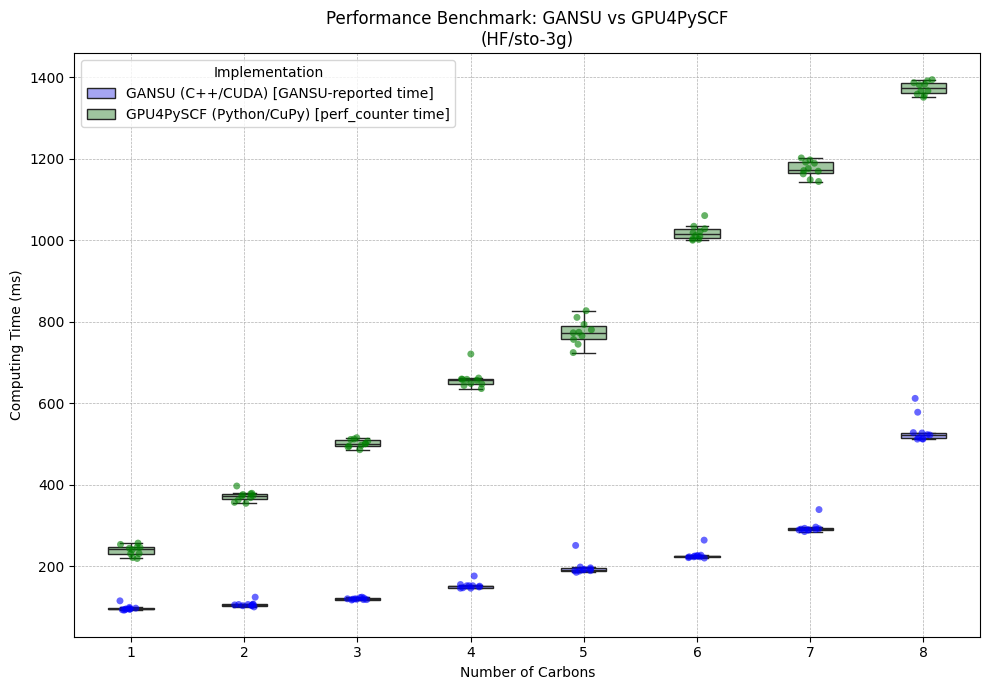

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ファイル名の定義
FILE_GANSU = "gansu_hf.csv"
FILE_GPU4PYSCF = "gpu4pyscf_hf.csv"

# メソッド名を定数化
METHOD_GANSU = "GANSU (C++/CUDA) [GANSU-reported time]"
METHOD_GPU4 = "GPU4PySCF (Python/CuPy) [perf_counter time]"

def main():
    # データの読み込み
    try:
        df_gansu = pd.read_csv(FILE_GANSU)
        df_gansu["Method"] = METHOD_GANSU

        df_gpu4 = pd.read_csv(FILE_GPU4PYSCF)
        df_gpu4["Method"] = METHOD_GPU4

        # データの結合
        df_all = pd.concat([df_gansu, df_gpu4], ignore_index=True)

    except FileNotFoundError as e:
        print(f"Error: CSV file not found. {e}")
        return

    # プロット設定
    plt.figure(figsize=(10, 7))

    # 並び順を固定するリスト
    my_hue_order = [METHOD_GANSU, METHOD_GPU4]

    # 色の定義
    my_palette = {METHOD_GANSU: "blue", METHOD_GPU4: "green"}

    # --- 箱ひげ図 ---
    # ★修正ポイント1: dodge=False を指定して、左右にずらさず中心に描画
    ax = sns.boxplot(
        x="n_carbon",
        y="time_ms",
        hue="Method",
        data=df_all,
        palette=my_palette,
        hue_order=my_hue_order,
        dodge=False,  # ★ここが重要：Falseにすると重ねて描画される
        width=0.4,    # 重ねる場合は少し細くすると見やすい場合があります
        showfliers=False
    )

    # ★修正ポイント2: 重なって見えなくならないよう、箱を半透明にする
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.4)) # アルファ値を0.4（40%不透明）に設定

    # --- ストリッププロット ---
    # ★修正ポイント3: 点も同様に dodge=False で中心に集める
    sns.stripplot(
        x="n_carbon",
        y="time_ms",
        hue="Method",
        data=df_all,
        dodge=False,  # ★点も中心に
        palette=my_palette,
        hue_order=my_hue_order,
        alpha=0.6,    # 点の透明度
        jitter=True,  # 中心付近で少し散らす
        legend=False,
        ax=ax
    )

    # グラフ装飾
    plt.title("Performance Benchmark: GANSU vs GPU4PySCF\n(HF/sto-3g)")
    plt.xlabel("Number of Carbons")
    plt.ylabel("Computing Time (ms)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # 凡例の位置調整
    plt.legend(title="Implementation")

    plt.tight_layout()
    plt.savefig("comparison_hf.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

## CCSD/sto-3g測定比較プロット

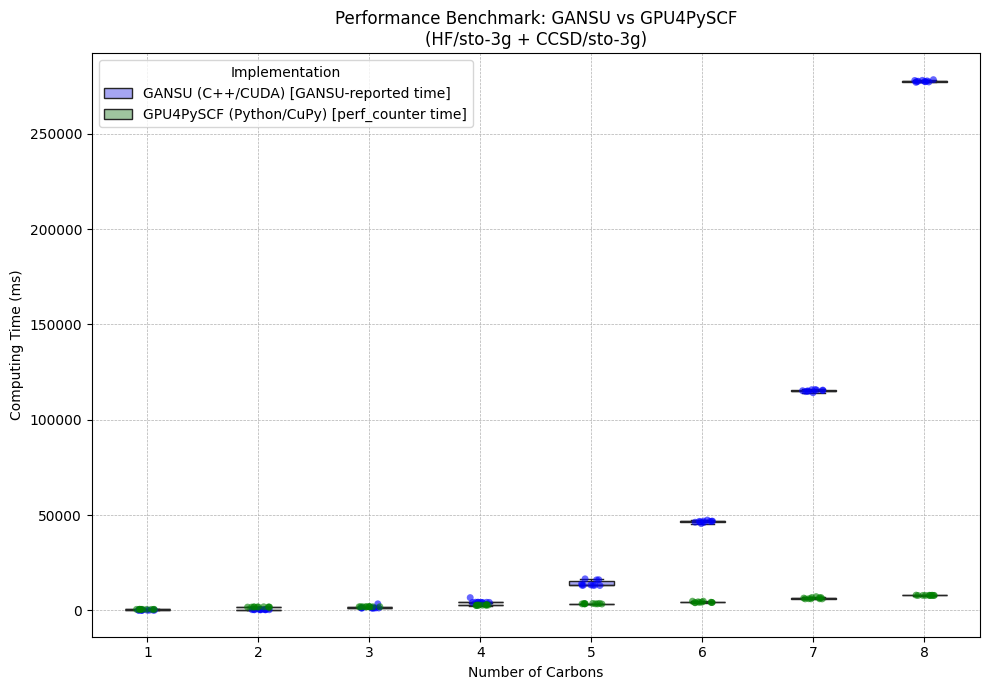

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ファイル名の定義
FILE_GANSU = "gansu_ccsd.csv"
FILE_GPU4PYSCF = "gpu4pyscf_ccsd.csv"

# メソッド名を定数化
METHOD_GANSU = "GANSU (C++/CUDA) [GANSU-reported time]"
METHOD_GPU4 = "GPU4PySCF (Python/CuPy) [perf_counter time]"

def main():
    # データの読み込み
    try:
        df_gansu = pd.read_csv(FILE_GANSU)
        df_gansu["Method"] = METHOD_GANSU

        df_gpu4 = pd.read_csv(FILE_GPU4PYSCF)
        df_gpu4["Method"] = METHOD_GPU4

        # データの結合
        df_all = pd.concat([df_gansu, df_gpu4], ignore_index=True)

    except FileNotFoundError as e:
        print(f"Error: CSV file not found. {e}")
        return

    # プロット設定
    plt.figure(figsize=(10, 7))

    # 並び順を固定するリスト
    my_hue_order = [METHOD_GANSU, METHOD_GPU4]

    # 色の定義
    my_palette = {METHOD_GANSU: "blue", METHOD_GPU4: "green"}

    # --- 箱ひげ図 ---
    # ★修正ポイント1: dodge=False を指定して、左右にずらさず中心に描画
    ax = sns.boxplot(
        x="n_carbon",
        y="time_ms",
        hue="Method",
        data=df_all,
        palette=my_palette,
        hue_order=my_hue_order,
        dodge=False,  # ★ここが重要：Falseにすると重ねて描画される
        width=0.4,    # 重ねる場合は少し細くすると見やすい場合があります
        showfliers=False
    )

    # ★修正ポイント2: 重なって見えなくならないよう、箱を半透明にする
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.4)) # アルファ値を0.4（40%不透明）に設定

    # --- ストリッププロット ---
    # ★修正ポイント3: 点も同様に dodge=False で中心に集める
    sns.stripplot(
        x="n_carbon",
        y="time_ms",
        hue="Method",
        data=df_all,
        dodge=False,  # ★点も中心に
        palette=my_palette,
        hue_order=my_hue_order,
        alpha=0.6,    # 点の透明度
        jitter=True,  # 中心付近で少し散らす
        legend=False,
        ax=ax
    )

    # グラフ装飾
    plt.title("Performance Benchmark: GANSU vs GPU4PySCF\n(HF/sto-3g + CCSD/sto-3g)")
    plt.xlabel("Number of Carbons")
    plt.ylabel("Computing Time (ms)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # 凡例の位置調整
    plt.legend(title="Implementation")

    plt.tight_layout()
    plt.savefig("comparison_ccsd.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    main()